In [1]:
import logging
import os
import sys
import shutil
import tempfile
import pandas as pd
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.networks.nets import resnet18
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /root/miniconda3/envs/cmri/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 10.0.1
Tensorboard version: 2.12.1
gdown version: 4.7.1
TorchVision version: 0.16.0
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

In [2]:
df = pd.read_csv('RANN_tidy_brain.csv')
df

,subid,Age,Sex,Race,Hispanic/Non-Hispanic,Education,WTARraw,WTAR_iq,DgtSym_NumCor,images
0,P00004253,73,M,B/AA,Y,12.0,22.0,84.0,53,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
1,P00004331,65,M,White,Y,20.0,45.0,119.0,80,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
2,P00004382,61,F,White,N,16.0,49.0,125.0,84,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
3,P00004387,61,F,White,N,14.0,25.0,89.0,86,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
4,P00004388,67,F,B/AA,N,18.0,28.0,93.0,43,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
...,...,...,...,...,...,...,...,...,...,...
254,P00004960,76,M,White,N,18.0,44.0,117.0,85,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
255,P00004962,77,F,White,N,18.0,50.0,126.0,85,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
256,P00004965,71,F,White,N,18.0,47.0,122.0,82,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...
257,P00004966,76,F,White,N,13.0,46.0,120.0,58,/home/yw4196/RANN/Deep_Learning_Brain_Images/P...


In [3]:
images = df["images"].tolist()
labels = df["DgtSym_NumCor"].tolist()

In [4]:
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(),Resize((128, 128, 128)), RandRotate90()])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((128, 128, 128))])

check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)

check_loader = DataLoader(check_ds, batch_size=2, num_workers = 0, pin_memory=pin_memory)
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([53, 80]) torch.Size([2])


In [5]:
from sklearn.model_selection import KFold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([53, 80]) torch.Size([2])


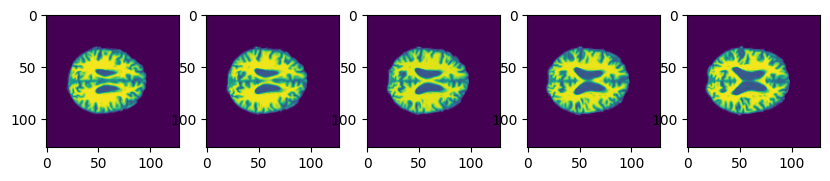

In [14]:
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(im[0, 0,:,59 + i])
    plt.gcf().set_size_inches(10, 10)
plt.show()

[53, 80, 84, 43, 85, 88, 80, 85, 57, 73, 75, 78, 72, 86, 88, 86, 80, 86, 64, 80, 85, 84, 79, 55, 73, 84, 78, 87, 86, 76, 84, 83, 82, 88, 70, 40, 71, 85, 87, 68, 78, 86, 76, 62, 86, 68, 85, 83, 88, 78, 84, 37, 80, 80, 80, 89, 84, 54, 86, 59, 82, 65, 86, 69, 86, 85, 88, 82, 87, 89, 68, 86, 86, 77, 82, 76, 55, 88, 78, 86, 64, 68, 87, 77, 82, 85, 88, 82, 77, 75, 74, 87, 86, 85, 79, 31, 85, 70, 88, 87, 85, 88, 84, 86, 67, 83, 85, 89, 85, 89, 84, 87, 89, 85, 79, 86, 63, 84, 83, 71, 49, 81, 86, 89, 49, 85, 84, 79, 40, 86, 86, 83, 71, 80, 88, 66, 83, 85, 87, 82, 89, 83, 87, 40, 71, 74, 83, 83, 80, 83, 84, 77, 84, 69, 87, 74, 85, 89, 89, 89, 85, 81, 87, 65, 84, 86, 86, 88, 1, 81, 89, 82, 84, 72, 71, 33, 86, 78, 85, 79, 79, 84, 85, 77, 55, 67, 39, 87, 84, 86, 89, 60, 75, 89, 37, 86, 86, 71, 83, 83, 86, 74, 70, 85, 82, 58, 69]
<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([86, 86]) torch.Size([2])


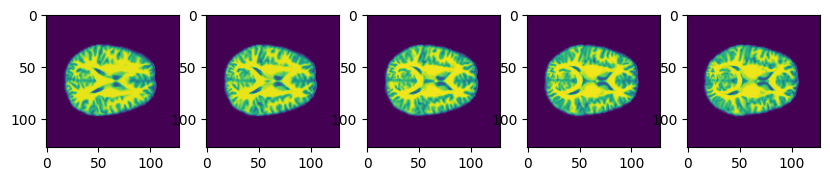

In [21]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(images)):
    # Split data
    train_images = [images[i] for i in train_ids]
    train_labels = [labels[i] for i in train_ids]
    test_images = [images[i] for i in test_ids]
    test_labels = [labels[i] for i in test_ids]

    # Create Dataset and DataLoader for training and validation
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=pin_memory)

    val_ds = ImageDataset(test_images, test_labels, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=2, pin_memory=pin_memory)
    im, label = monai.utils.misc.first(train_loader)
    print(type(im), im.shape, label, label.shape)
    for i in range(5):
        plt.subplot(5, 5,i + 1)
        plt.imshow(im[0, 0,:,59 + i])
        plt.gcf().set_size_inches(10, 10)
    plt.show()
    break

In [7]:
from monai.networks.nets import Regressor

model = Regressor(in_shape=[1, 128, 128, 128], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)
model = model.to(device)
loss_function = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), 1e-5)


In [3]:
resnet18(
    pretrained=False,
    spatial_dims=3,
    n_input_channels=1,
    num_classes=1  # Change the number of output classes to 1 for regression
)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [26]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create Dataset and DataLoader for training
train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, num_workers=0, shuffle=True, pin_memory=pin_memory)

# Create Dataset and DataLoader for testing
test_ds = ImageDataset(image_files=test_images, labels=test_labels, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=2, pin_memory=pin_memory)


In [29]:
#model = net.to(device)
from monai.networks.nets import Regressor

model = Regressor(in_shape=[1, 128, 128, 128], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)
model = model.to(device)
# loss_function = torch.nn.MSELoss()
loss_function = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = 9999
best_metric_epoch = -1
epoch_loss_values = []
loss_val = 0
#writer = SummaryWriter()
max_epochs = 8

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = torch.squeeze(model(inputs), 1)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        #writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

#         num_correct = 0.0
#         metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = torch.squeeze(model(val_images), 1)
                value = abs(val_outputs.cpu().numpy()-val_labels.cpu().numpy())
                loss_val += np.sum(value)
        metric = loss_val / len(val_ds)
        print(f"val_loss: {metric:.4f}")

#         metric = num_correct / metric_count
#         metric_values.append(metric)

        if metric < best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_regressor_RANN.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        # writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/8
1/103, train_loss: 84.4011
2/103, train_loss: 77.2062
3/103, train_loss: 70.5997
4/103, train_loss: 72.9756
5/103, train_loss: 65.4677
6/103, train_loss: 60.2399
7/103, train_loss: 53.3249
8/103, train_loss: 26.2625
9/103, train_loss: 43.6303
10/103, train_loss: 33.0427
11/103, train_loss: 28.1595
12/103, train_loss: 15.0910
13/103, train_loss: 1.5568
14/103, train_loss: 4.8096
15/103, train_loss: 20.6440
16/103, train_loss: 44.9702
17/103, train_loss: 24.2125
18/103, train_loss: 7.5267
19/103, train_loss: 4.1435
20/103, train_loss: 4.8266
21/103, train_loss: 4.4657
22/103, train_loss: 26.5464
23/103, train_loss: 10.3462
24/103, train_loss: 5.0986
25/103, train_loss: 4.1002
26/103, train_loss: 2.3865
27/103, train_loss: 3.3892
28/103, train_loss: 1.8015
29/103, train_loss: 9.6785
30/103, train_loss: 14.0517
31/103, train_loss: 2.1077
32/103, train_loss: 2.6192
33/103, train_loss: 9.0427
34/103, train_loss: 4.1642
35/103, train_loss: 11.2086
36/103, train_loss: 5.87

In [25]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(images)):
    # Split data
    train_images = [images[i] for i in train_ids]
    train_labels = [labels[i] for i in train_ids]
    test_images = [images[i] for i in test_ids]
    test_labels = [labels[i] for i in test_ids]

    # Create Dataset and DataLoader for training and validation
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=pin_memory)

    val_ds = ImageDataset(image_files=test_images, labels= test_labels, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=2, pin_memory=pin_memory)

    # Initialize/Reset the model and optimizer for each fold
    model = Regressor(in_shape=[1, 128, 128, 128], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)
    model = model.to(device)
    loss_function = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)


    # Example training/validation process
    max_epochs = 5
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        # Training loop
        for batch_data in train_loader:
            step += 1
            inputs, targets = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = torch.squeeze(model(inputs),1)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data in val_loader:
                inputs, targets = batch_data[0].to(device), batch_data[1].to(device)
                outputs = torch.squeeze(model(inputs), 1)
                loss = loss_function(outputs, targets)
                val_loss += loss.item()

        val_len = len(val_ds) // val_loader.batch_size
        avg_train_loss = epoch_loss / epoch_len
        avg_val_loss = val_loss / val_len
        print(f"Average Training Loss: {avg_train_loss:.4f}")
        print(f"Average Validation Loss: {avg_val_loss:.4f}")

    print(f'Fold {fold + 1} completed')


----------
Epoch 1/5
1/103, train_loss: 86.7858
2/103, train_loss: 82.8418
3/103, train_loss: 55.5018
4/103, train_loss: 71.3766
5/103, train_loss: 63.4570
6/103, train_loss: 55.5794
7/103, train_loss: 58.3079
8/103, train_loss: 50.3986
9/103, train_loss: 39.7629
10/103, train_loss: 24.8437
11/103, train_loss: 21.4392
12/103, train_loss: 5.9407
13/103, train_loss: 4.3347
14/103, train_loss: 11.6548
15/103, train_loss: 20.0634
16/103, train_loss: 14.9030
17/103, train_loss: 14.9180
18/103, train_loss: 14.5733
19/103, train_loss: 14.7246
20/103, train_loss: 9.5346
21/103, train_loss: 23.7055
22/103, train_loss: 19.4860
23/103, train_loss: 13.6107
24/103, train_loss: 3.5058
25/103, train_loss: 26.3948
26/103, train_loss: 4.2983
27/103, train_loss: 4.5707
28/103, train_loss: 14.9052
29/103, train_loss: 11.5574
30/103, train_loss: 32.5550
31/103, train_loss: 18.4917
32/103, train_loss: 4.5427
33/103, train_loss: 11.7657
34/103, train_loss: 4.7056
35/103, train_loss: 19.2075
36/103, train_lo

In [7]:
#from monai import model_constructor
net = resnet18(
    pretrained=False,
    spatial_dims=3,
    n_input_channels=1,
    num_classes=1  # Change the number of output classes to 1 for regression
)
net_dict = net.state_dict()
pretrain = torch.load("resnet_18_23dataset.pth")
pretrain['state_dict'] = {k.replace('module.', ''): v for k, v in pretrain['state_dict'].items()}
# #missing = tuple({k for k in net_dict.keys() if k not in pretrain['state_dict']})
# #logging.debug(f"missing in pretrained: {len(missing)}")
# #inside = tuple({k for k in pretrain['state_dict'] if k in net_dict.keys()})
# #logging.debug(f"inside pretrained: {len(inside)}")
# #unused = tuple({k for k in pretrain['state_dict'] if k not in net_dict.keys()})
# #logging.debug(f"unused pretrained: {len(unused)}")
# assert len(inside) > len(missing)
# assert len(inside) > len(unused)

pretrain['state_dict'] = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
net.load_state_dict(pretrain['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['layer2.0.downsample.0.weight', 'layer2.0.downsample.0.bias', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.0.bias', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.0.downsample.1.running_mean', 'layer3.0.downsample.1.running_var', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.0.bias', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'fc.weight', 'fc.bias'], unexpected_keys=[])

In [9]:
torch.save(model.state_dict(), "reg_MONAI_Snapshot_brain.pth")

In [30]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [31]:
# Get a random image and its corresponding label
img, label = get_next_im()


In [33]:
for name, _ in model.named_modules(): print(name)


net
net.layer_0
net.layer_0.conv
net.layer_0.conv.unit0
net.layer_0.conv.unit0.conv
net.layer_0.conv.unit0.adn
net.layer_0.conv.unit0.adn.N
net.layer_0.conv.unit0.adn.A
net.layer_0.conv.unit1
net.layer_0.conv.unit1.conv
net.layer_0.conv.unit1.adn
net.layer_0.conv.unit1.adn.N
net.layer_0.conv.unit1.adn.A
net.layer_0.residual
net.layer_1
net.layer_1.conv
net.layer_1.conv.unit0
net.layer_1.conv.unit0.conv
net.layer_1.conv.unit0.adn
net.layer_1.conv.unit0.adn.N
net.layer_1.conv.unit0.adn.A
net.layer_1.conv.unit1
net.layer_1.conv.unit1.conv
net.layer_1.conv.unit1.adn
net.layer_1.conv.unit1.adn.N
net.layer_1.conv.unit1.adn.A
net.layer_1.residual
net.layer_2
net.layer_2.conv
net.layer_2.conv.unit0
net.layer_2.conv.unit0.conv
net.layer_2.conv.unit0.adn
net.layer_2.conv.unit0.adn.N
net.layer_2.conv.unit0.adn.A
net.layer_2.conv.unit1
net.layer_2.conv.unit1.conv
net.layer_2.conv.unit1.adn
net.layer_2.conv.unit1.adn.N
net.layer_2.conv.unit1.adn.A
net.layer_2.residual
net.layer_3
net.layer_3.conv


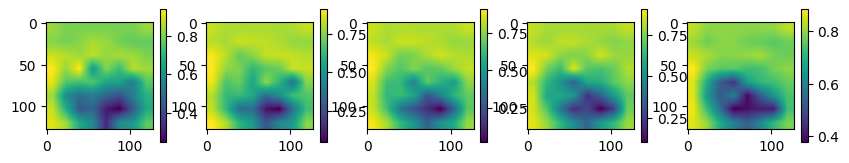

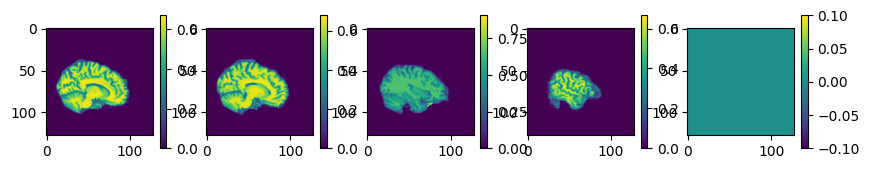

In [54]:
from monai.visualize import GradCAMpp
cam = GradCAMpp(nn_module=model, target_layers="net.layer_3")
result = cam(x=img)
a = 0
b = 0
d = 59

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(result[a, b, d + i, :, :].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(img[a, b, d + i, :, :].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

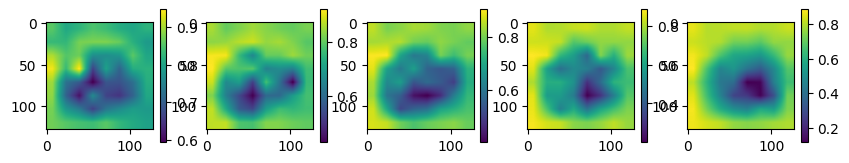

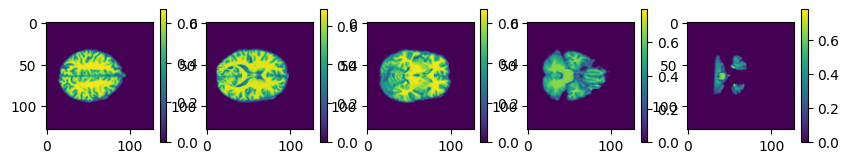

In [53]:
from monai.visualize import GradCAMpp
cam = GradCAMpp(nn_module=model, target_layers="net.layer_3")
result = cam(x=img)
a = 0
b = 0
d = 59

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(result[a, b, :, d + i,:].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(img[a, b, :,d + i,:].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

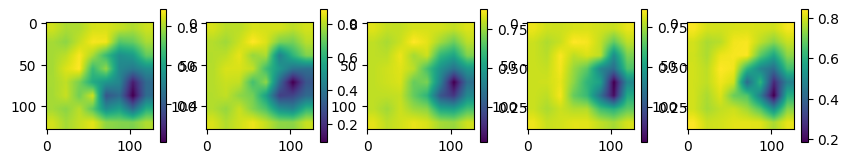

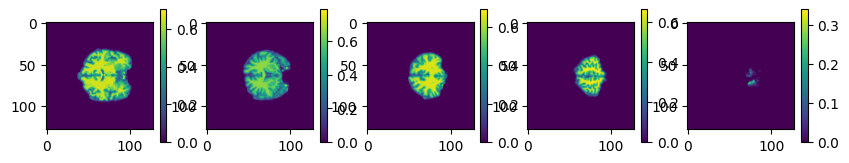

In [52]:
cam = GradCAMpp(nn_module=model, target_layers="net.layer_3")
result = cam(x=img)
a = 0
b = 0
d = 59

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(result[0, 0, :,:, d + i].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(img[a, 0, :, :, d + i].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

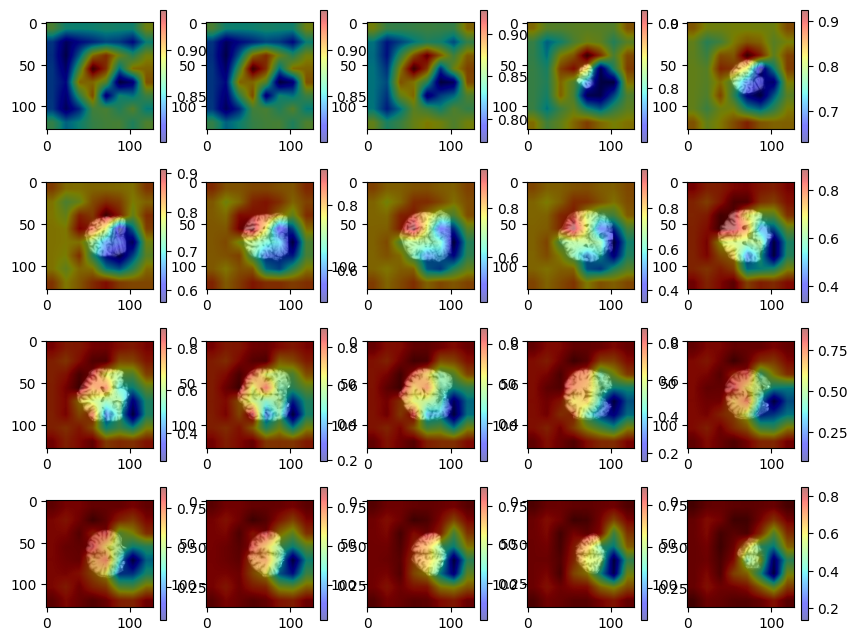

In [66]:
import matplotlib.pyplot as plt

# Assuming 'result' is your Grad-CAM heatmap and 'img' is your original image
# a, b, and d are your specified indices

for i in range(0, 100, 5):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 5 + 1)

    # Original image slice
    original_slice = img[a, 0, :, :, i].cpu().numpy()
    plt.imshow(original_slice, cmap='gray')  # Grayscale is assumed, change if needed

    # Heatmap slice
    heatmap_slice = result[0, 0, :, :, i].cpu().numpy()
    plt.imshow(heatmap_slice, cmap='jet', alpha=0.5)  # Overlay with transparency

    plt.colorbar()  # Add a colorbar for each overlaid image
    plt.gcf().set_size_inches(10, 10)  # Adjust the figure size as needed

plt.show()


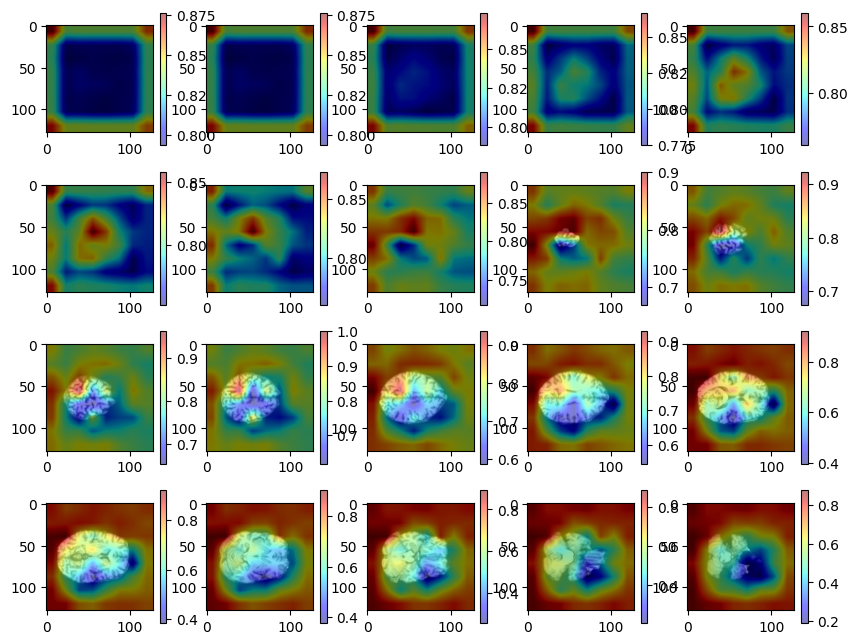

In [61]:
import matplotlib.pyplot as plt

# Assuming 'result' is your Grad-CAM heatmap and 'img' is your original image
# a, b, and d are your specified indices

for i in range(0, 100, 5):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 5 + 1)

    # Original image slice
    original_slice = img[a, 0, :, i,:].cpu().numpy()
    plt.imshow(original_slice, cmap='gray')  # Grayscale is assumed, change if needed

    # Heatmap slice
    heatmap_slice = result[0, 0, :, i, :].cpu().numpy()
    plt.imshow(heatmap_slice, cmap='jet', alpha=0.5)  # Overlay with transparency

    plt.colorbar()  # Add a colorbar for each overlaid image
    plt.gcf().set_size_inches(10, 10)  # Adjust the figure size as needed

plt.show()


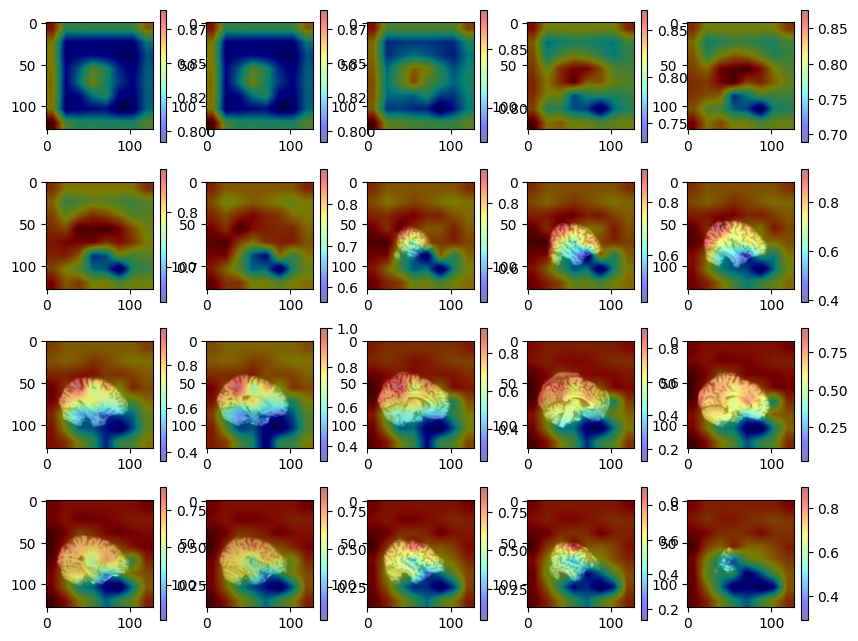

In [67]:
import matplotlib.pyplot as plt

# Assuming 'result' is your Grad-CAM heatmap and 'img' is your original image
# a, b, and d are your specified indices

for i in range(0, 100, 5):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 5 + 1)

    # Original image slice
    original_slice = img[a, 0, 0 + i,:, :].cpu().numpy()
    plt.imshow(original_slice, cmap='gray')  # Grayscale is assumed, change if needed

    # Heatmap slice
    heatmap_slice = result[0, 0, 0 + i,:,:].cpu().numpy()
    plt.imshow(heatmap_slice, cmap='jet', alpha=0.5)  # Overlay with transparency

    plt.colorbar()  # Add a colorbar for each overlaid image
    plt.gcf().set_size_inches(10, 10)  # Adjust the figure size as needed

plt.show()
